# Hyperparameters and Model Validation

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [40]:
import os
if not os.path.exists('figures'):
    os.makedirs('figures')
    
plt.style.context('ggplot')

## Thinking about Model Validation

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

### Model validation the wrong way

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [3]:
model.fit(X, y)
y_model = model.predict(X)

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model! But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

As you may have gathered, the answer is no. In fact, this approach contains a fundamental flaw: it trains and evaluates the model on the same data. 

### Model validation the right way: Holdout sets

Split dataset into train set and test set

In [7]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5, test_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

### Model validation via cross-validation

One way to address this is to use cross-validation; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.

In [11]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data. This would be rather tedious to do by hand, and so we can use Scikit-Learn's cross_val_score convenience routine to do it succinctly

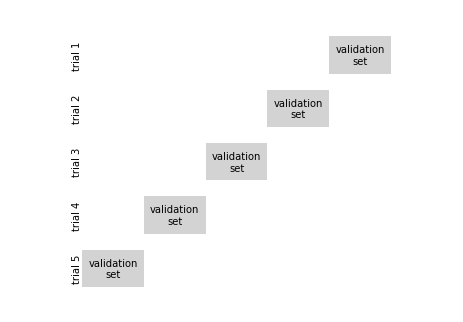

In [23]:
def draw_rects(N, ax, textprop={}):
    for i in range(N):
        ax.add_patch(plt.Rectangle((0, i), 5, 0.7, fc='white'))
        ax.add_patch(plt.Rectangle((5. * i / N, i), 5. / N, 0.7, fc='lightgray'))
        ax.text(5. * (i + 0.5) / N, i + 0.35,
                "validation\nset", ha='center', va='center', **textprop)
        ax.text(0, i + 0.35, "trial {0}".format(N - i),
                ha='right', va='center', rotation=90, **textprop)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-0.2, N + 0.2)
    
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
draw_rects(5, ax, textprop=dict(size=10))

fig.savefig('figures/05.03-5-fold-CV.png')

In [15]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [16]:
scores.mean()

0.96

We might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial. This type of cross-validation is known as leave-one-out cross validation, and can be used as follows

In [13]:
from sklearn.cross_validation import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials

In [14]:
scores.mean()

0.96

## Selecting the Best Model

### The Bias-variance trade-off

Take care of underfit and overfit!

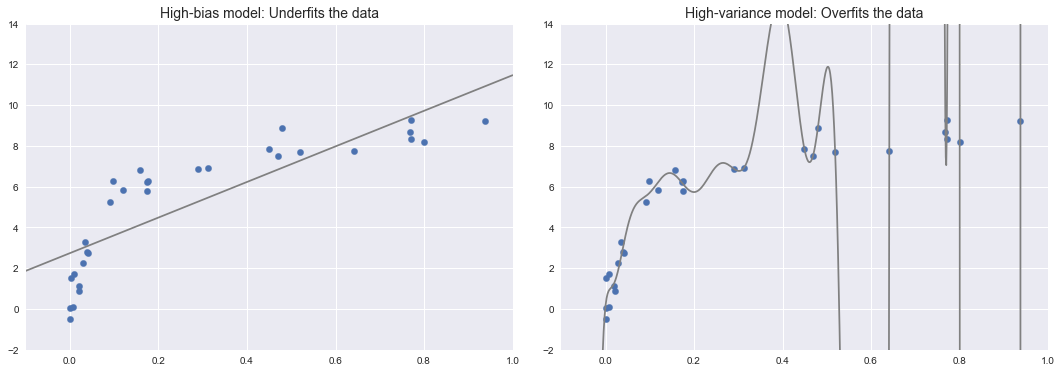

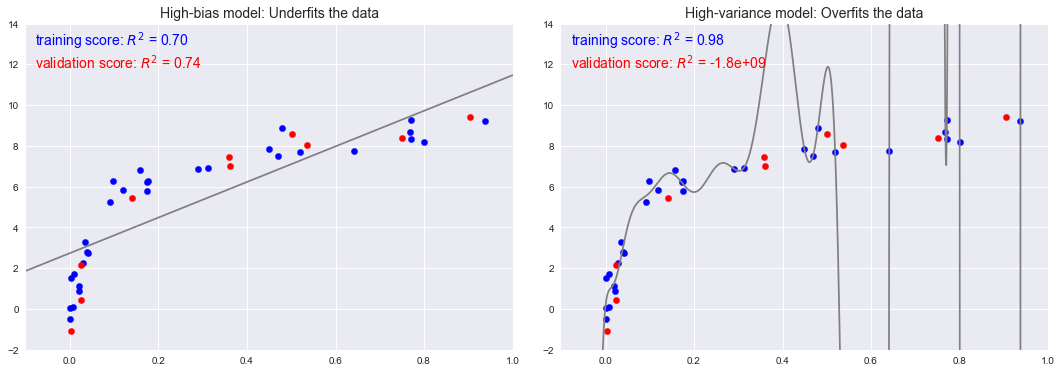

In [41]:
import numpy as np

def make_data(N=30, err=0.8, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

X, y = make_data()
xfit = np.linspace(-0.1, 1.0, 1000)[:, None]
model1 = PolynomialRegression(1).fit(X, y)
model20 = PolynomialRegression(20).fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].scatter(X.ravel(), y, s=40)
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)

ax[1].scatter(X.ravel(), y, s=40)
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)

fig.savefig('figures/05.03-bias-variance.png')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

X2, y2 = make_data(10, rseed=42)

ax[0].scatter(X.ravel(), y, s=40, c='blue')
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)
ax[0].scatter(X2.ravel(), y2, s=40, c='red')
ax[0].text(0.02, 0.98, "training score: $R^2$ = {0:.2f}".format(model1.score(X, y)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='blue')
ax[0].text(0.02, 0.91, "validation score: $R^2$ = {0:.2f}".format(model1.score(X2, y2)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='red')

ax[1].scatter(X.ravel(), y, s=40, c='blue')
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)
ax[1].scatter(X2.ravel(), y2, s=40, c='red')
ax[1].text(0.02, 0.98, "training score: $R^2$ = {0:.2g}".format(model20.score(X, y)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='blue')
ax[1].text(0.02, 0.91, "validation score: $R^2$ = {0:.2g}".format(model20.score(X2, y2)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='red')

fig.savefig('figures/05.03-bias-variance-2.png')

The score here is the $R^2$ score, or coefficient of determination, which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models. From the scores associated with these two models, we can make an observation that holds more generally:

* For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
* For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.


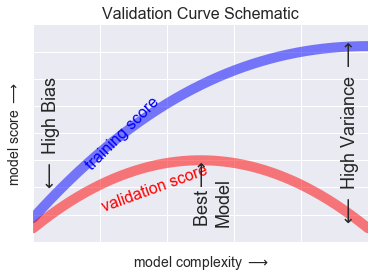

In [38]:
plt.style.context('ggplot')
x = np.linspace(0, 1, 1000)
y1 = -(x - 0.5) ** 2
y2 = y1 - 0.33 + np.exp(x - 1)

fig, ax = plt.subplots()
ax.plot(x, y2, lw=10, alpha=0.5, color='blue')
ax.plot(x, y1, lw=10, alpha=0.5, color='red')

ax.text(0.15, 0.2, "training score", rotation=45, size=16, color='blue')
ax.text(0.2, -0.05, "validation score", rotation=20, size=16, color='red')

ax.text(0.02, 0.1, r'$\longleftarrow$ High Bias', size=18, rotation=90, va='center')
ax.text(0.98, 0.1, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.48, -0.12, 'Best$\\longrightarrow$\nModel', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(-0.3, 0.5)

ax.set_xlabel(r'model complexity $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Validation Curve Schematic", size=16)

fig.savefig('figures/05.03-validation-curve.png')

The diagram shown here is often called a validation curve, and we see the following essential features:

* The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
* For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
* For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
* For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.


### Validation curves in Scikit-Learn

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [30]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

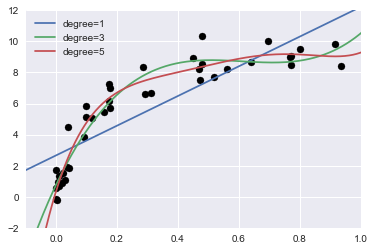

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the validation_curve convenience routine provided by Scikit-Learn

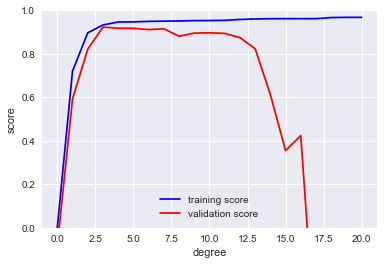

In [33]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows

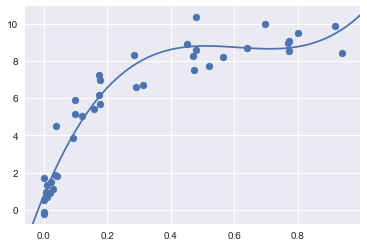

In [34]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

## Learning Curves

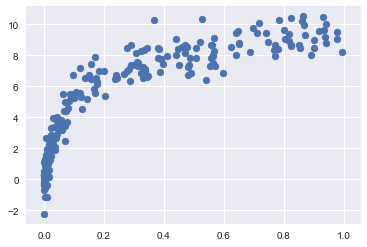

In [49]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

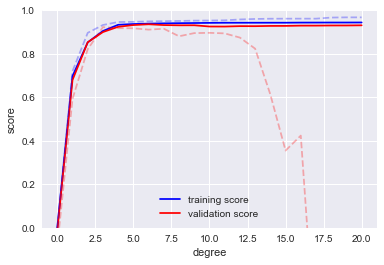

In [50]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

The general behavior we would expect from a learning curve is this:

* A model of a given complexity will overfit a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
* A model of a given complexity will underfit a large dataset: this means that the training score will decrease, but the validation score will increase.
* A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.


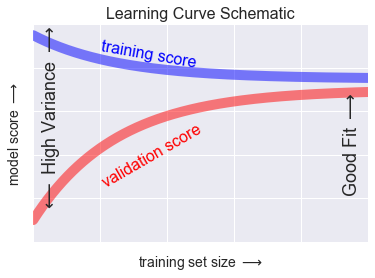

In [42]:
N = np.linspace(0, 1, 1000)
y1 = 0.75 + 0.2 * np.exp(-4 * N)
y2 = 0.7 - 0.6 * np.exp(-4 * N)

fig, ax = plt.subplots()
ax.plot(x, y1, lw=10, alpha=0.5, color='blue')
ax.plot(x, y2, lw=10, alpha=0.5, color='red')

ax.text(0.2, 0.88, "training score", rotation=-10, size=16, color='blue')
ax.text(0.2, 0.5, "validation score", rotation=30, size=16, color='red')

ax.text(0.98, 0.45, r'Good Fit $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.02, 0.57, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel(r'training set size $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Learning Curve Schematic", size=16)

fig.savefig('figures/05.03-learning-curve.png')

### Learning curves in Scikit-Learn

Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial

/home/jbuisine/.pyenv/versions/3.6.5/envs/tensorflow/lib/python3.6/site-packages/sklearn/learning_curve.py:235: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes' 15 instead of 25).
  % (train_sizes_abs.shape[0], n_ticks), RuntimeWarning)
/home/jbuisine/.pyenv/versions/3.6.5/envs/tensorflow/lib/python3.6/site-packages/sklearn/learning_curve.py:235: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes' 15 instead of 25).
  % (train_sizes_abs.shape[0], n_ticks), RuntimeWarning)


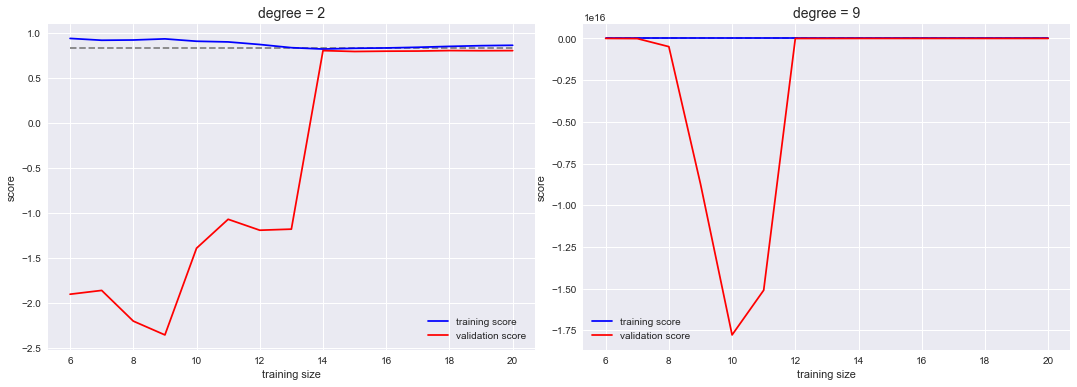

In [55]:
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=3,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    #ax[i].set_ylim(0, 1)
    #ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data. In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) adding more training data will not significantly improve the fit! This situation is seen in the left panel, with the learning curve for the degree-2 model

## Validation in Practice: Grid Search

Scikit-Learn provides automated tools to do this in the grid search module. Here is an example of using grid search to find the optimal polynomial model. We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem. This can be set up using Scikit-Learn's GridSearchCV meta-estimator

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [58]:
grid.fit(X, y);

In [59]:
grid.best_params_

{'linearregression__fit_intercept': True,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 5}

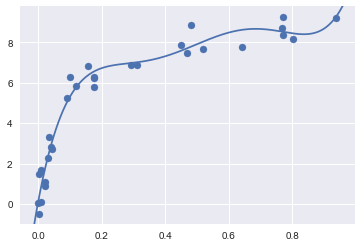

In [61]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

## Summary

In this section, we have begun to explore the concept of model validation and hyperparameter optimization, focusing on intuitive aspects of the bias–variance trade-off and how it comes into play when fitting models to data. In particular, we found that the use of a validation set or cross-validation approach is vital when tuning parameters in order to avoid over-fitting for more complex/flexible models.